In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
from jax.scipy.special import expit as sigmoid
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata
from sklearn.metrics import confusion_matrix

from jaxbo.mcmc_models import MultifidelityGPclassifier
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.input_priors import uniform_prior

onp.random.seed(1234)

## Generate some data

In [2]:
def low_fidelity(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5 - X[:,1]) > 0
    
def high_fidelity(X):
    return ( 0.5 + np.sin(2.5*X[:,0]*np.pi)/3 - X[:,1]) > 0
    
def low_fidelity_boundary(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5)
    
def high_fidelity_boundary(X):
    return (0.5 + np.sin(2.5*X[:,0]*np.pi)/3)

In [3]:
D = 2
NL = 50 # number of low fidelity points
NH = 10 # number of high fidelity points
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, ub)

# Training data
XL = lb + (ub - lb)*lhs(D,NL) # generate data with a Latin hypercube desing
yL = 1.0*low_fidelity(XL)

# to generate the high fidelity data we choose some points
# from both of classes in the low fidelity data
ind1 = np.where(yL > 0)[0]
ind0 = np.where(yL == 0)[0]

XH1 = XL[onp.random.choice(ind1, int(NH/2), replace = False)]
XH0 = XL[onp.random.choice(ind0, int(NH/2), replace = False)]

XH = np.concatenate([XH1, XH0], axis = 0)
yH = 1.0*high_fidelity(XH)

y = np.concatenate([yL, yH])

# Test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = 1.0*high_fidelity(X_star)

## Model setup

In [4]:
options = {'kernel': 'RBF',
           'criterion': 'CLSF', 
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 20,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = MultifidelityGPclassifier(options)

## Training

In [5]:
rng_key = random.PRNGKey(123)
data = {'XL': XL, 'XH': XH, 'y': y}
print('Train GP...')
key_train, key_test = random.split(rng_key)
samples = gp_model.train(data,
                         key_train,
                         mcmc_settings,
                         verbose = True)

Train GP...


sample: 100%|██████████| 520/520 [00:19<00:00, 27.15it/s, 63 steps of size 6.10e-02. acc. prob=0.98] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta_H      0.02      1.10     -0.19     -1.70      1.94     34.79      1.05
            beta_L      0.02      0.56      0.26     -0.99      0.71     23.27      0.97
          eta_H[0]      0.40      1.03      0.18     -1.37      1.62     23.08      0.95
          eta_H[1]     -0.03      1.05     -0.00     -2.04      1.19     20.27      0.97
          eta_H[2]      0.12      1.15      0.57     -1.98      1.36     21.61      1.01
          eta_H[3]      0.00      0.95      0.04     -1.36      1.68     19.32      1.01
          eta_H[4]     -0.02      0.67     -0.08     -0.88      1.12     14.66      1.06
          eta_H[5]     -0.34      1.35     -0.55     -1.85      1.86     28.03      0.97
          eta_H[6]     -0.00      1.18      0.08     -1.75      1.72     49.72      0.95
          eta_H[7]      0.05      0.87     -0.09     -1.30      1.31   -452.41      0.96
          eta_H[8]  

In [6]:
# Compute predictions
rng_keys = random.split(key_test, 
                        mcmc_settings['num_samples'] * mcmc_settings['num_chains'])
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
mean, std = gp_model.predict(X_star, **kwargs)
acq_fn = lambda x: gp_model.acquisition(x, **kwargs)
acq = vmap(acq_fn)(X_star)
new_X = gp_model.compute_next_point_gs(X_star, **kwargs)
acc_total = np.sum(np.rint(sigmoid(mean)) == y_star)/y_star.shape[0]
print('Classification accuracy: %f%%' % (acc_total))

Classification accuracy: 0.885600%


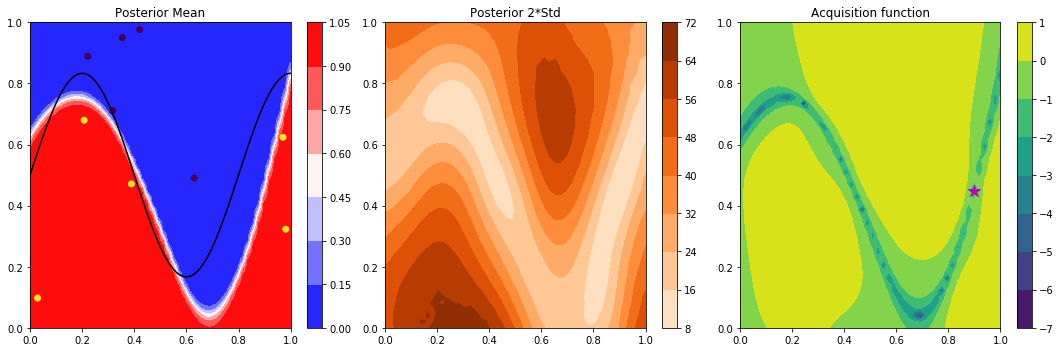

In [7]:
Mplot = mean.reshape(nn,nn)
Splot = std.reshape(nn,nn)
Aplot = acq.reshape(nn,nn)

xx = np.linspace(0, 1, 100)[:,None]

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.contourf(XX, YY, sigmoid(Mplot), cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar()
plt.scatter(XH[:,0], XH[:,1], c = yH)
plt.plot(xx , high_fidelity_boundary(xx), 'k', label = 'high-fidelity boundary')
plt.title('Posterior Mean')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.contourf(XX, YY, 2.0*Splot, cmap=plt.get_cmap('Oranges'), vmin=0)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior 2*Std')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.contourf(XX, YY, Aplot)
plt.plot(new_X[0,0], new_X[0,1], 'm*', ms = 12)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

In [8]:
# Fit GMM
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)

In [9]:
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'gmm_vars': gmm_vars}
w_pred = compute_w_gmm(X_star, **kwargs)
acq = np.log(np.abs(mean)+1e-8) - np.log(std + 1e-8) - np.log(w_pred + 1e-8)
# acq = np.abs(mean)/(std*w_pred)
new_X = X_star[np.argmin(acq), :]

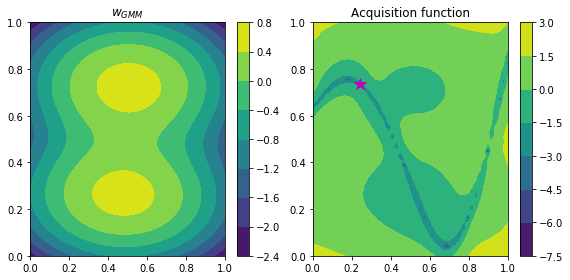

In [10]:
Wplot = w_pred.reshape(nn,nn)
AAplot = acq.reshape(nn,nn)

plt.figure(figsize = (8,4))
plt.subplot(1, 2, 1)
plt.contourf(XX, YY, np.log(Wplot))
plt.colorbar()
plt.title('$w_{GMM}$')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.contourf(XX, YY, AAplot)
plt.colorbar()
plt.plot(new_X[0], new_X[1], 'm*', ms = 12)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()